# <CENTER> ЗАДАЧА КЛАССИФИКАЦИИ
    
## <CENTER> PROJECT 4

## ЦЕЛЬ:

**Построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


**Данные о клиентах банка:**

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

**Прочие признаки:**

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная `deposit`, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

Исследуем данные на предмет пропусков. 

In [3]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

**Есть ли в признаке `job` пропущенные значения? Возможно, они обозначены каким-то специальным словом?**


In [4]:
df['job'].describe()

count          11162
unique            12
top       management
freq            2566
Name: job, dtype: object

In [5]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

**Преобразуем признак `balance` таким образом, чтобы он корректно считывался, как вещественное число (float)**

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [7]:
df['balance'].head()

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object

In [8]:
df['balance'] = df['balance'].str.replace(',', '.')

In [9]:
df['balance'] = df['balance'].str.replace('$', '')

In [10]:
df['balance'] = df['balance'].str.replace(' ', '')

In [11]:
df['balance'].value_counts()

0          774
1.00        39
3.00        34
2.00        34
4.00        29
          ... 
1641.00      1
5517.00      1
8332.00      1
4859.00      1
-134.00      1
Name: balance, Length: 3802, dtype: int64

In [12]:
df['balance'].describe()

count     11137
unique     3802
top           0
freq        774
Name: balance, dtype: object

Теперь поменяем тип признака на `float`

In [13]:
df['balance'] = df['balance'].map(lambda x: float(x))

In [14]:
df['balance'].describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

### Работа с пропусками


**Обработаем пропуски в признаки balance , заменив их на медианные значения по данному признаку**


In [15]:
df['balance'].fillna(df['balance'].median(), inplace = True)

In [16]:
df['balance'].describe()

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

**Ранее мы выяснили, что в признаке job есть пропущенные значения, которые не отображаются как пропуски в явном виде. Однако нам всё равно важно их обработать. Мы знаем, что для категориальных признаков пропущенные значения заменяются модой по данному признаку.**

**Обработаем пропуски в категориальных признаках: `job` и `education`, заменив их на модальные значения**


In [17]:
m_col= df['job'].mode()[0]
df['job'] = df['job'].apply(lambda x: m_col if x == 'unknown' else x)

In [18]:
m_col= df['education'].mode()[0]
df['education'] = df['education'].apply(lambda x: m_col if x == 'unknown' else x)

**После замены пропусков рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование).**

In [19]:
#Посмотрим на самую популярную работу:
df['job'].value_counts()

management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

In [20]:
#Посмотрим на самое популярное образование:
df['education'].value_counts()

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

In [21]:
df.groupby(['job', 'education'])['balance'].mean().unstack()


education,primary,secondary,tertiary
job,,,
admin.,775.928571,1189.494662,1343.482143
blue-collar,1304.818444,1125.866889,1730.062500
entrepreneur,1314.707317,1304.445161,2090.189394
housemaid,1366.444444,1018.229885,2069.162791
management,1841.534247,1598.882979,1826.104710
retired,2222.631769,2594.966759,2314.992857
self-employed,1254.928571,1373.517007,2254.047826
services,1383.554217,1028.724269,1279.754717
student,1492.047619,1333.574219,2018.722892


**Итак, средний баланс у нас равен `1598.882979`**

### ВЫБРОСЫ

**Удалим все выбросы для признака `balance`.
Найдем верхнюю и нижнюю границы поиска выбросов по методу Тьюки.**


<AxesSubplot:>

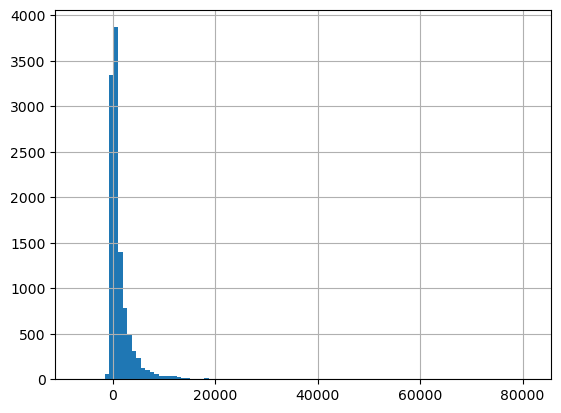

In [22]:
df['balance'].hist(bins=100)

<AxesSubplot:>

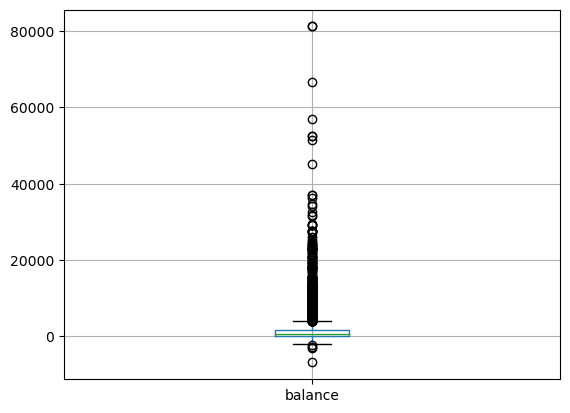

In [23]:
df.boxplot(column=['balance'])

In [24]:
df['balance'].describe()

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

In [25]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    print("Нижняя граница: ",lower_bound,"Верхняя граница: ",upper_bound)
    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'balance')
print('Результирующее число записей: ', len(df['balance'])- outliers.shape[0])

Нижняя граница:  -2241.0 Верхняя граница:  4063.0
Результирующее число записей:  10105


**Удалим все выбросы:**


In [26]:
df = df.drop(outliers.index, axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


## Часть 2:  Разведывательный анализ

**Изучим соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируем результат**


**Посмотрим сколько клиентов открыли депозит?**

<AxesSubplot:>

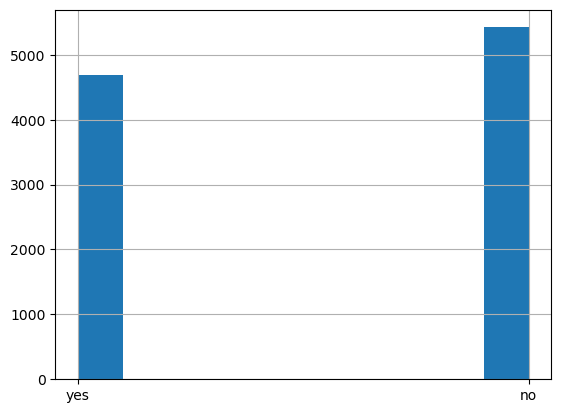

In [27]:
df['deposit'].hist()

**Вывод: Как видим бОльшая часть клиентов все-таки отказалась открывать депозит в этом банке.**

In [28]:
df['deposit'].head()

0    yes
1    yes
2    yes
3    yes
4    yes
Name: deposit, dtype: object

In [29]:
df_yes = df['deposit']
count = 0 #задаём начальное количество символов 'yes'
#создаём цикл по элементам списка df_yes

for i in df_yes:
    if i=='yes':
        count+=1
print(count)

4681


In [30]:
df_no = df['deposit']
count = 0 #задаём начальное количество символов 'yes'
#создаём цикл по элементам списка df_yes

for i in df_no:
    if i=='no':
        count+=1
print(count)

5424


**Начнём с описательных статистик для количественных переменных.**

- Рассчитайте их и продумайте подробную интерпретацию.
- Попробуйте описать данные, которые у вас есть, увидеть первые зависимости.
- Рассмотрите минимальные и максимальные значения.
- Посмотрите на меры разброса и оцените, насколько данные вариативны.
- Сравнив меры центральной тенденции, сделайте выводы о том, есть ли аномальные значения с меньшей или большей стороны.
- Дополните выводы визуализациями. Вспомните, какие диаграммы могут помочь в иллюстрации распределений количественных данных.

**Рассчитаем описательные статистики для количественных переменных, проинтерпретируем результат**

**Посмотрим на максимальный возраст клиента банка?**

In [31]:
df['age'].max()

95

<AxesSubplot:>

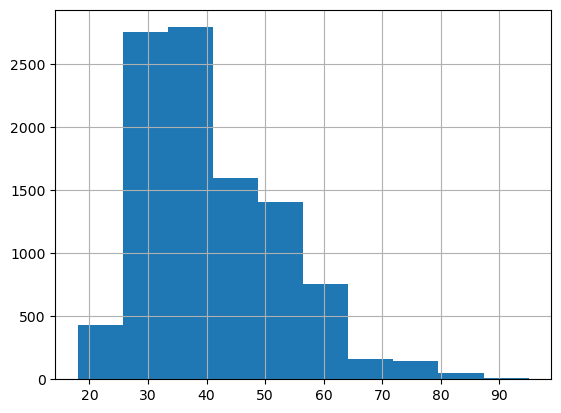

In [32]:
df['age'].hist()

**Вывод: в основном депозит открывают в возрасте от 26лет до 64лет**

**Какова минимальная продолжительность разговора с клиентом банка?**

In [33]:
df['duration'].min()

2

<AxesSubplot:>

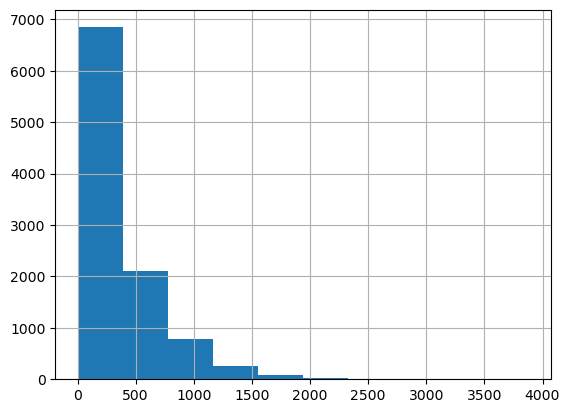

In [34]:
df['duration'].hist()

**Вывод: скорее всего это был срыв звонка.**

**Теперь давайте рассмотрим описательные статистики для категориальных переменных.**

**Попробуем извлечь максимум информации из тех показателей, которые можете получить. Сколько всего сфер занятости представлено среди клиентов банка? В каждый ли месяц проходила маркетинговая кампания? Какое семейное положение встречается чаще всего? А образование?**

**Рассчитаем описательные статистики для категориальных переменных.
Построем визуализации, иллюстрирующие результаты**

**Сколько было месяцев, в которых проводилась маркетинговая кампания?**

<AxesSubplot:xlabel='poutcome'>

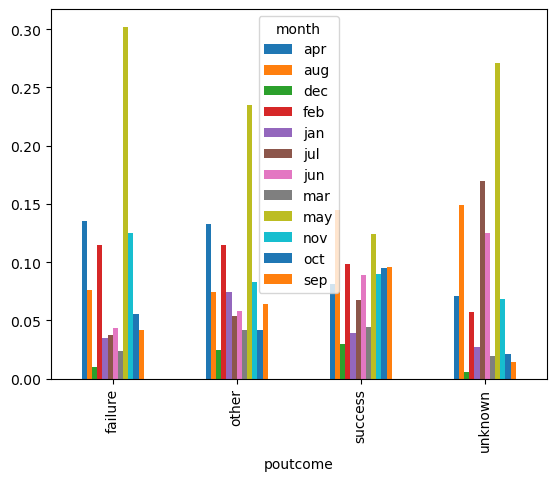

In [35]:
res = df.groupby("poutcome")['month'].value_counts(normalize=True).unstack()
res.plot(kind='bar')

<AxesSubplot:xlabel='count', ylabel='month'>

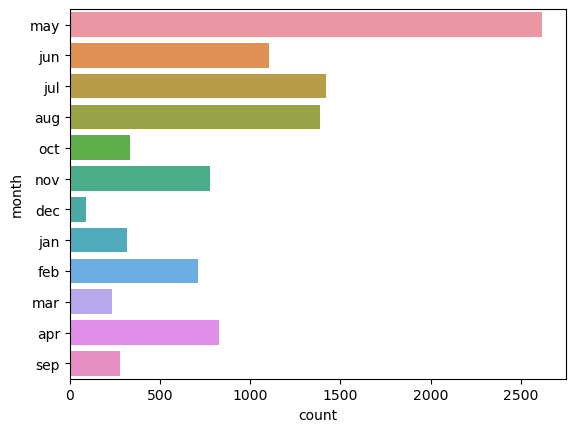

In [49]:
sns.countplot(y='month',data=df)

In [36]:
df['month'].count()

10105

**Сколько сфер занятости представлено среди клиентов банка?**

In [37]:
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'self-employed', 'student'], dtype=object)

**Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.**


<AxesSubplot:xlabel='poutcome'>

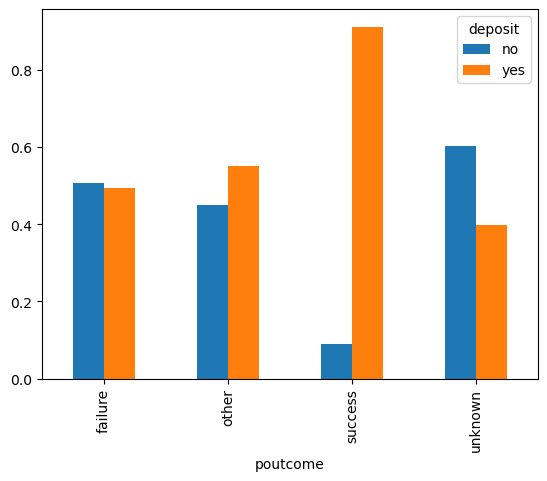

In [38]:
res = df.groupby("poutcome")['deposit'].value_counts(normalize=True).unstack()
res.plot(kind='bar')

**Узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит**


<AxesSubplot:xlabel='month'>

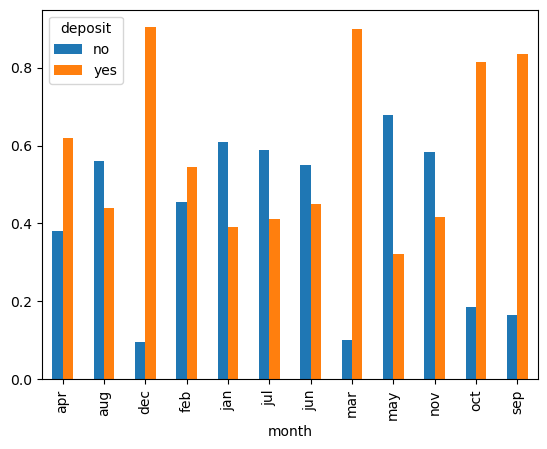

In [39]:
res = df.groupby("month")['deposit'].value_counts(normalize=True).unstack()
res.plot(kind='bar')

**Создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения**

<AxesSubplot:xlabel='age_5'>

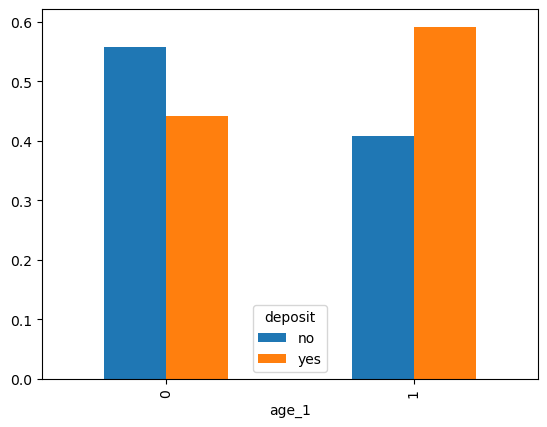

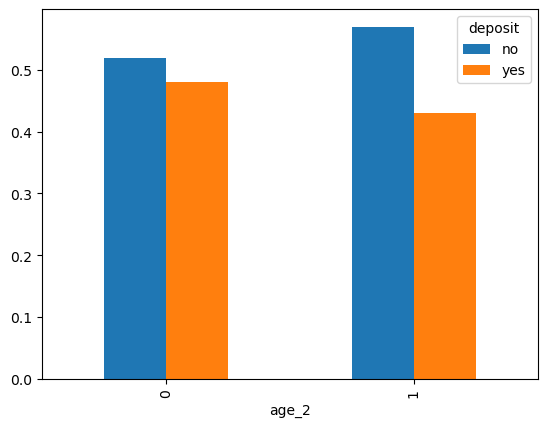

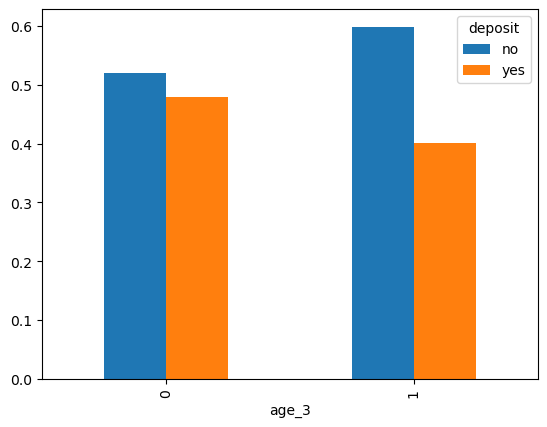

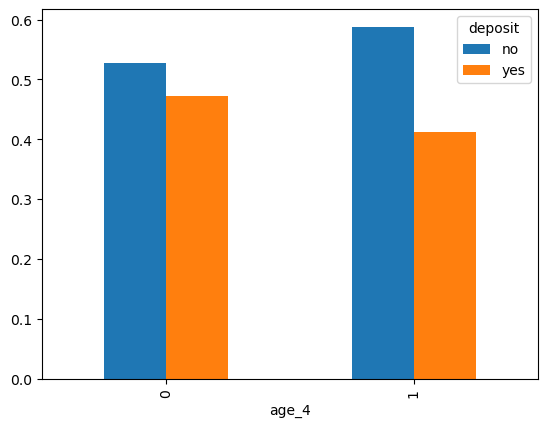

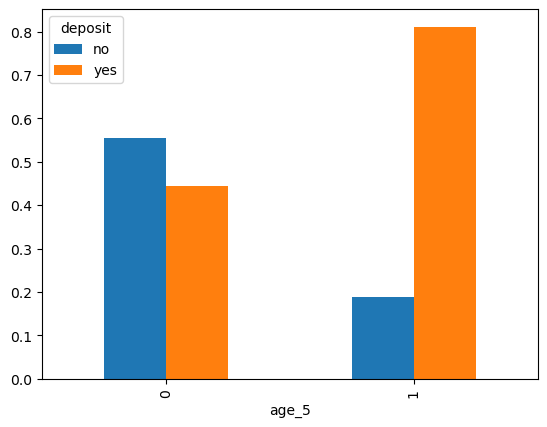

In [40]:
df['age_1']=df['age'].apply(lambda x: 1 if x < 30 else 0)
df['age_2']=df['age'].apply(lambda x: 1 if ((x > 30) & (x < 40)) else 0)
df['age_3']=df['age'].apply(lambda x: 1 if ((x > 40) & (x < 50)) else 0)
df['age_4']=df['age'].apply(lambda x: 1 if ((x > 50) & (x < 60)) else 0)
df['age_5']=df['age'].apply(lambda x: 1 if x > 60 else 0)

res = df.groupby('age_1')['deposit'].value_counts(normalize=True).unstack()
res.plot(kind='bar')

res = df.groupby('age_2')['deposit'].value_counts(normalize=True).unstack()
res.plot(kind='bar')   
res = df.groupby('age_3')['deposit'].value_counts(normalize=True).unstack()
res.plot(kind='bar')   
res = df.groupby('age_4')['deposit'].value_counts(normalize=True).unstack()
res.plot(kind='bar')   
res = df.groupby('age_5')['deposit'].value_counts(normalize=True).unstack()
res.plot(kind='bar')   

**Вывод: Чаще открывают депозит люди до 30 и страше 60 лет**

**Давайте посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:**

- семейное положение;
- уровень образования;
- сфера занятости.

**Построим визуализации, отражающие количество тех, кто открыл депозит, и тех, кто его не открыл, для всех категорий предложенных выше трёх признаков. Постараемся оформить диаграммы максимально наглядно и описать полученный результат.**

**К каким категориям относится бόльшая часть людей? Среди каких групп населения есть тенденция соглашаться открывать депозит, а среди каких — отказываться?**

**Построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса**

<AxesSubplot:xlabel='marital'>

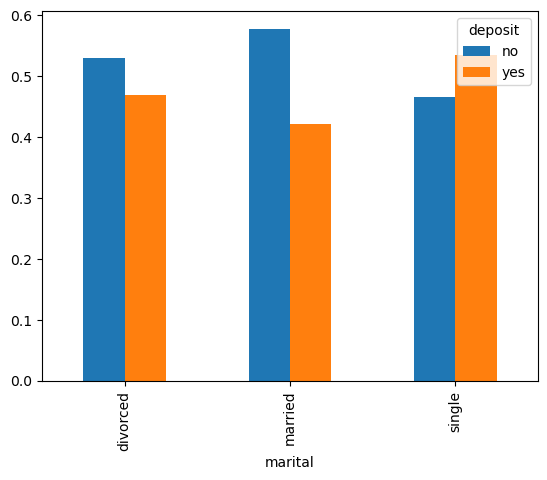

In [41]:
res = df.groupby('marital')['deposit'].value_counts(normalize=True).unstack()
res.plot(kind='bar')   

**Вывод: Чаще открывают депозит люди не состоящие никогда в браке**

**Построим визуализации для открывших и неоткрывших депозит в зависимости от образования**

<AxesSubplot:xlabel='education'>

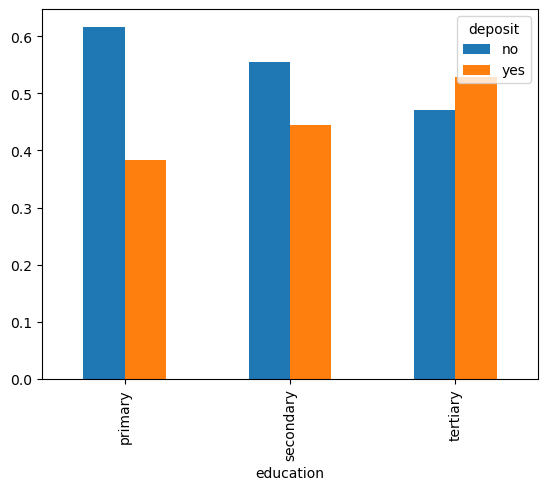

In [42]:
res = df.groupby('education')['deposit'].value_counts(normalize=True).unstack()
res.plot(kind='bar') 

**Построим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости**

<AxesSubplot:xlabel='count', ylabel='job'>

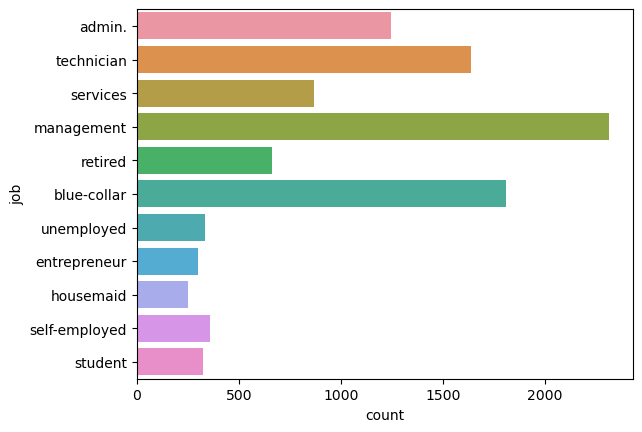

In [48]:
sns.countplot(y='job',data=df) 

**Построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
(если рассматривать тех, кто открыл депозит)**

In [44]:
pos_1 = df[df.deposit == 'yes'][['education','marital','deposit']]
pos_2 = df[df.deposit == 'no'][['education','marital','deposit']] 

In [45]:
cross_1 = pd.crosstab(pos_1['education'], pos_1['marital'])
cross_2 = pd.crosstab(pos_2['education'], pos_2['marital'])

<AxesSubplot:xlabel='marital', ylabel='education'>

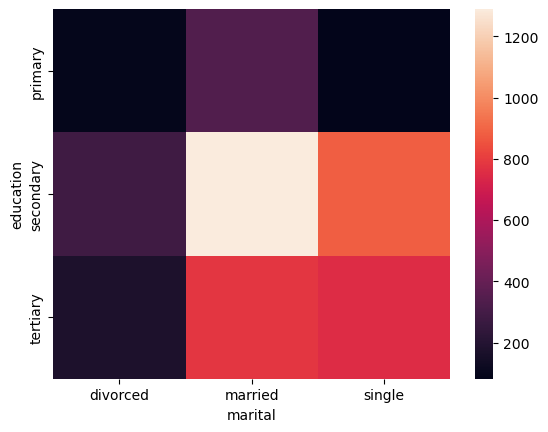

In [46]:
import seaborn as sns
#построим тепловую матрицу, чтобы было легче найти нужные значения
sns.heatmap(cross_1)

<AxesSubplot:xlabel='marital', ylabel='education'>

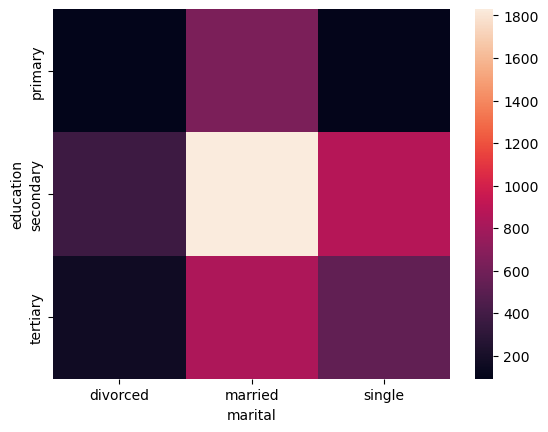

In [47]:
import seaborn as sns
#построим тепловую матрицу, чтобы было легче найти нужные значения
sns.heatmap(cross_2)

**Вывод: Люди с высшим образованием и находящиеся в браке самые многочисленные.**

## Часть 3: преобразование данных


**Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: `education`.
Обработаем его с помощью метода LabelEncoder, используя метод без дополнительных настроек.**

In [54]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
df['education'] = lab_enc.fit_transform(df['education'])
df['education'].sum()

11995

**Ранее мы создали порядковую переменную для возраста. Обработаем её по такому же принципу, чтобы её можно было использовать при обучении модели.**

In [55]:
df['age_1'] = lab_enc.fit_transform(df['age_1'])
df['age_2'] = lab_enc.fit_transform(df['age_2'])
df['age_3'] = lab_enc.fit_transform(df['age_3'])
df['age_4'] = lab_enc.fit_transform(df['age_4'])
df['age_5'] = lab_enc.fit_transform(df['age_5'])

**БИНАРНОЕ КОДИРОВАНИЕ**

Обычно в задачах бинарной классификации целевую переменную кодируют как бинарный признак, который принимает значения 1 или 0. Так как наш проект будет соответствовать всем правилам хорошего тона, давайте перекодируем переменную `deposit` таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.

Напишем соответствующую функцию

In [56]:
def bin_func(row):
    if row == 'yes':
        return 1
    else:
        return 0

df['deposit'] = df['deposit'].apply(bin_func)

Вычислим стандартное отклонение по преобразованной в корректный вид целевой переменной deposit

In [57]:
df['deposit'].std()

0.4986712532451993

Сделаем то же самое для других бинарных переменных, которых у нас три:

`'default'`;
`'housing'`;
`'loan'`.
Все три мы будем модифицировать ровно так же: для слова `yes` мы возьмём в качестве значения 1, а для `no` — 0.

In [58]:
df['default'] = df['default'].apply(bin_func)
df['housing'] = df['housing'].apply(bin_func)
df['loan'] = df['loan'].apply(bin_func)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,deposit,age_1,age_2,age_3,age_4,age_5
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,1,-1,0,unknown,1,0,0,0,1,0
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,1,-1,0,unknown,1,0,0,0,1,0
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,1,-1,0,unknown,1,0,0,1,0,0
3,55,services,married,1,0,2476.0,1,0,unknown,5,...,1,-1,0,unknown,1,0,0,0,1,0
4,54,admin.,married,2,0,184.0,0,0,unknown,5,...,2,-1,0,unknown,1,0,0,0,1,0


In [59]:
mean_3=df['loan'].mean()+df['housing'].mean()+df['default'].mean()
mean_3

0.6354280059376547

**Создание dummy-переменных**

Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:

- 'job';
- 'marital';
- 'contact';
- 'month';
- 'poutcome'.

Создадим для них dummy-переменные и добавьте их в набор данных.

In [60]:
categorial_features = ['job', 'marital', 'contact', 'month', 'poutcome']
df1= pd.get_dummies(df[categorial_features])
df = pd.concat([df,df1], axis = 1)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
4,54,admin.,married,2,0,184.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1


### Мультиколлинеарность 

Теперь давайте оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Для этого построим матрицу корреляций. 
Дополним её тепловой картой, отражающей результат. Для того, чтобы вычислить коэффициенты корреляции, необходимо, чтобы целевая переменная была числовой.

Также построим столбчатую диаграмму для ранжированных коэффициентов корреляции.

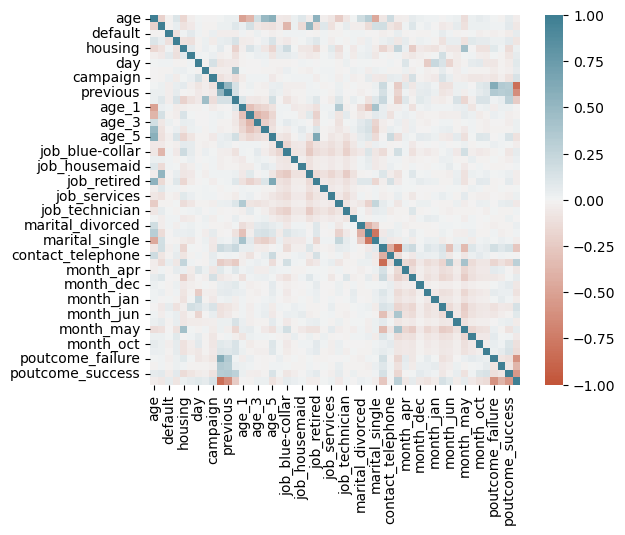

In [61]:
corr = df.corr()

#sns.set(rc={'figure.figsize':(10, 10)})

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)

In [62]:
new_corr = corr['deposit'].reset_index()
sort_corr = new_corr.sort_values('deposit', ascending=False)
sort_corr.head()

,index,deposit
11,deposit,1.000000
7,duration,0.457818
48,poutcome_success,0.288491
31,contact_cellular,0.223944
16,age_5,0.161247


In [63]:
df['age'].corr(df['age_1'], method = 'pearson') #  kendall spearman
df['age'].corr(df['age_2'], method = 'pearson') #  kendall spearman
df['age'].corr(df['age_3'], method = 'pearson') #  kendall spearman
df['age'].corr(df['age_4'], method = 'pearson') #  kendall spearman
df['age'].corr(df['age_5'], method = 'pearson') #  kendall spearman

0.5706367170150847

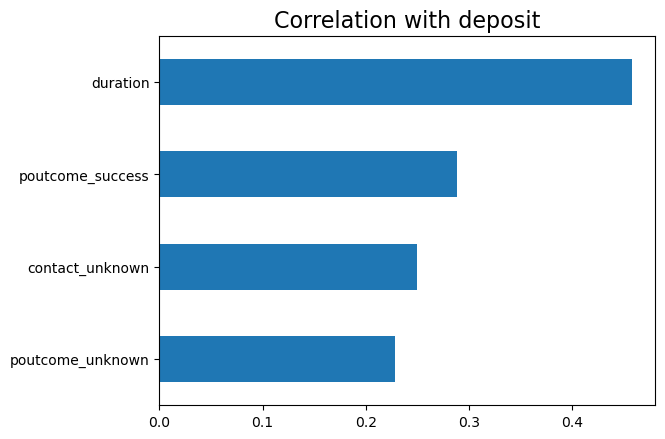

In [64]:
corr["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

**Теперь  определим целевую переменную и предикторы, а также разделим выборку на обучающую и тестовую.**

При разбиении зададим параметр random_state = 42, а размер тестовой выборки возьмем за 0.33, и добавим аргумент, определяющий сохранение соотношений целевого признака.

In [65]:
df = df.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1)

In [66]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

Каким получился размер тестовой выборки?

Каково среднее значение целевой переменной на тестовой выборке?

In [67]:
print(y_test.shape)
print(y_test.mean())

(3335,)
0.46326836581709147


**На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.**

С помощью SelectKBest отберем 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуем по обучающей выборке, используя параметр `score_func = f_classif`.

На данном этапе вам необходимо оставить только те признаки, которые содержат лишь числовые значения.

In [68]:
from sklearn.feature_selection import SelectKBest, f_classif
select_k_best_classifier = SelectKBest(score_func=f_classif, k=15).fit(X_train, y_train)
select_k_best_classifier.get_support()
feature_names = list(X_train.columns.values)
mask = select_k_best_classifier.get_support()
new_features = []

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
new_features

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_5',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Нормализация

Теперь данные необходимо нормализовать.

Есть разные варианты нормализации, но мы будем использовать min-max-нормализацию.

Нормализация требуется для предикторов, а не для целевой переменной.

Нормализуем предикторы в обучающей и тестовой выборках.

In [70]:
df = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'age_5', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [71]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_test_scaled[:, 0].mean())  # для признака balance

0.46823674223097866


In [72]:
len(X_test_scaled)

3335

In [73]:
df.head()

,balance,housing,duration,campaign,pdays,previous,age_5,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown,deposit
0,2343.0,1,1042,1,-1,0,0,0,1,0,1,0,0,0,1,1
1,45.0,0,1467,1,-1,0,0,0,1,0,1,0,0,0,1,1
2,1270.0,1,1389,1,-1,0,0,0,1,0,1,0,0,0,1,1
3,2476.0,1,579,1,-1,0,0,0,1,0,1,0,0,0,1,1
4,184.0,0,673,2,-1,0,0,0,1,0,1,0,0,0,1,1


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Логистическая регрессия

Для начала реализуем самый простой алгоритм, который нам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать `'sag'`, в качестве значения параметра `random_state` возьмём число `42` и запустим `1000` итераций.

Оценим качество модели на тестовой выборке.

Для получившейся модели вычислите значение accuracy на тестовой выборке

In [74]:
log_reg = linear_model.LogisticRegression(
    solver='sag', random_state=42, max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)
y_train_pred = log_reg.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.81      0.80      3335

Test accuracy: 0.81


### Решающие деревья

Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:

- criterion = 'entropy';
- random_state = 42.

Остальные параметры оставим по умолчанию.

In [75]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)

print('Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))

y_test_pred = dt.predict(X_test_scaled)

print('Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train: 0.81
Test: 0.80


### Оптимизация

Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Давайте реализуем оптимизацию гиперпараметров с помощью `GridSearch`, перебрав следующие параметры:

`'min_samples_split'`: [2, 5, 7, 10];
`'max_depth'`:[3,5,7].

In [76]:
from sklearn.model_selection import GridSearchCV
parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}
model_cv = GridSearchCV(tree.DecisionTreeClassifier(), parameters,
 cv=3, scoring=('f1'), return_train_score=True)
model_cv.fit(X_train_scaled, y_train)

print("Наилучшие значения параметров: {}".format(model_cv.best_params_))

y_test_pred = model_cv.predict(X_test_scaled)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 5}
f1_score на тестовом наборе: 0.78


In [77]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.80      0.76      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



**По сути, мы уже решили задачу классификации: отобрали признаки, обучили модель, сделали прогноз и оценили его качество. Однако не будем останавливаться на достигнутом — попробуем более сложные модели и варианты оптимизации**

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Случайный лес

Обучим случайный лес со следующими параметрами:

- n_estimators = 100;
- criterion = 'gini';
- min_samples_leaf = 5;
- max_depth = 10;
- random_state = 42.

In [78]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print()
print('Train: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))
print('Test recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Train: 0.85
Test accuracy: 0.82

Train: 0.84
Test recall: 0.82


### Градиентный бустинг

Дата-сайентист не должен останавливаться на одной модели — он должен пробовать все доступные варианты. Поэтому теперь предлагаем вам сравнить полученные результаты с моделью градиентного бустинга. Используйте градиентный бустинг для решения задачи классификации, задав для него следующие параметры:

- learning_rate = 0.05;
- n_estimators = 300;
- min_samples_leaf = 5;
- max_depth = 5;
- random_state = 42.

In [79]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

y_train_pred = gb.predict(X_train_scaled)

print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = gb.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.87
Test: 0.81


### Стекинг

Мы уже попробовали построить разные модели, и теперь пришло время построить ансамбль из моделей разного типа.

Используем стекинг, объединив те алгоритмы, которые мы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используем модель логистической регрессии.

Параметры оставим те же, что были в наших алгоритмах выше.

In [80]:
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

y_train_pred = stack.predict(X_train_scaled)
#print('Train: {:.2f}'.format(metrics.precision(y_train, y_train_pred)))
y_test_pred = stack.predict(X_test_scaled)
#print('Test: {:.2f}'.format(metrics.precision(y_test, y_test_pred)))

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1790
           1       0.81      0.80      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Отбор признаков

Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

In [81]:
estimators = [
('dtc', tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)),
('rf', ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)),
('gb', ensemble.GradientBoostingClassifier(min_samples_leaf=5, learning_rate=0.05, n_estimators=300, max_depth=5, random_state=42))
]
#Создаем объект класса стекинг
reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42))

#Обучаем модель
reg.fit(X_train_scaled, y_train)

# Выводим значения метрики
y_train_pred = reg.predict(X_train_scaled)
print('F1 Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = reg.predict(X_test_scaled)
print('F1 Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1 Train: 0.86
F1 Test: 0.81


**Оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга**

Feature: 0, Score: 0.05965
Feature: 1, Score: 0.04567
Feature: 2, Score: 0.50975
Feature: 3, Score: 0.01852
Feature: 4, Score: 0.05377
Feature: 5, Score: 0.00739
Feature: 6, Score: 0.02703
Feature: 7, Score: 0.00454
Feature: 8, Score: 0.07949
Feature: 9, Score: 0.02734
Feature: 10, Score: 0.01448
Feature: 11, Score: 0.01926
Feature: 12, Score: 0.01275
Feature: 13, Score: 0.12010
Feature: 14, Score: 0.00027


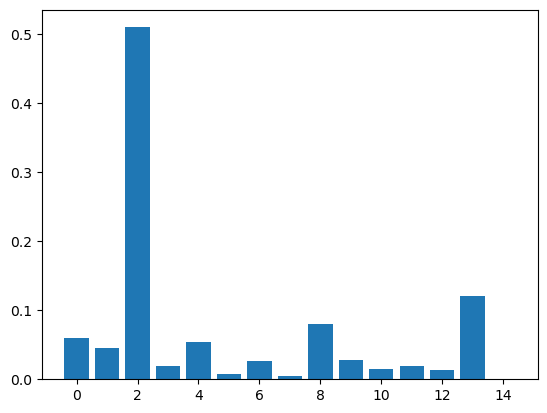

In [82]:
import matplotlib.pyplot  as plt
importance = gb.feature_importances_
for i,v in enumerate(importance):
  print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Оптимизация гиперпараметров

Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи `GridSearch`. Однако мы знаем, что это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna. Применим его для оптимизации гиперпараметров. Для перебора возьмем случайный лес и следующие параметры:

n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
max_depth = trial.suggest_int('max_depth', 10, 30, 1);
min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

In [ ]:
#!pip install optuna

In [83]:
import optuna

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

study = optuna.create_study()

study.optimize(optuna_rf, n_trials=20)
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)

print("accuracy на тестовом наборе: {:.3f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))



[I 2022-11-19 16:40:49,432] A new study created in memory with name: no-name-760f752b-77ec-448c-be05-c5a2e12368ce
[I 2022-11-19 16:40:50,044] Trial 0 finished with value: 0.8398486759142497 and parameters: {'n_estimators': 185, 'max_depth': 11, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8398486759142497.
[I 2022-11-19 16:40:50,629] Trial 1 finished with value: 0.8438287153652394 and parameters: {'n_estimators': 175, 'max_depth': 30, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8398486759142497.
[I 2022-11-19 16:40:51,560] Trial 2 finished with value: 0.917717528373266 and parameters: {'n_estimators': 197, 'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8398486759142497.
[I 2022-11-19 16:40:52,185] Trial 3 finished with value: 0.8606801441780286 and parameters: {'n_estimators': 166, 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8398486759142497.
[I 2022-11-19 16:40:52,839] Trial 4 finished with value: 0.8375019663363221

accuracy на тестовом наборе: 0.822
f1_score на тестовом наборе: 0.809


In [85]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42
                                          )
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

[I 2022-11-19 22:30:24,834] A new study created in memory with name: RandomForestClassifier
[I 2022-11-19 22:30:25,338] Trial 0 finished with value: 0.8495769351300533 and parameters: {'n_estimators': 129, 'max_depth': 29, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8495769351300533.
[I 2022-11-19 22:30:26,017] Trial 1 finished with value: 0.8513980521520578 and parameters: {'n_estimators': 194, 'max_depth': 29, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8513980521520578.
[I 2022-11-19 22:30:26,742] Trial 2 finished with value: 0.8476925500078752 and parameters: {'n_estimators': 188, 'max_depth': 17, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8513980521520578.
[I 2022-11-19 22:30:27,390] Trial 3 finished with value: 0.8866238042966913 and parameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8866238042966913.
[I 2022-11-19 22:30:28,066] Trial 4 finished with value: 0.8884711779448621 and parameters: {'n_